In [ ]:
## project configurations
from elasticsearch import Elasticsearch
from datetime import datetime
from dateutil.relativedelta import relativedelta
import dateparser

es = Elasticsearch()
index_name = "esdocs"
origin_date = None # to be setup later from index
search_operator = "OR" # "AND" (strict) or "OR" (loose)
geo_range_km = 10000000
date_format = "%d-%b-%Y %H:%M:%S"

In [ ]:
## querying functions
def query_index(query):
  """
  Query the index with the given query and return the `hits` array
  """
  res = es.search(index=index_name, body=query)
  print(res)
  print(f"Total results: {res['hits']['total']['value']}. Took: {res['took']}ms.")
  res_arr = res['hits']['hits']
  print('Showing Top Results:')
  return res_arr

def temporal_date_diff(date_input) -> int:
  """
  Return the number of days between the given date and the current date
  """
  base_date = datetime.now()
  relative_date = dateparser.parse(date_input, settings={'RELATIVE_BASE': base_date})
  if relative_date:
    days = (relative_date - base_date).days
  else:
    days = None
  return days

def autocomplete_document_titles(user_input, type="full") -> list:
  """
  - Autocompletes document titles based on user input.
  #### Args
    user_input (tuple): `query`, `temp_date_diff`, `geo_ref`.
    type: results output mode. `full` ''default'' or `minimal` (only titles)
  #### Returns
    list: A list of documents that match the user input.
  """
  if not user_input[0]:
    print("Please provide a valid title")
    return None
  
  title_match = {
    "multi_match": {
      "query": user_input[0],
      "fields": "title^3",
      "boost": 3,
      "operator":"AND"
    }
  }

  title_body_fuzzy = {
    "multi_match": {
      "query": user_input[0],
      "fields": ["title^3", "content"],
      "fuzziness": "AUTO:3,6",
      "operator": "OR",
      "boost": 1
    }
  }
  
  temporal_filter = {
    "term": {
      "expressions": {
        "value": user_input[1],
      }
    }
  }

  date_decay = {
    "exp": {
      "date": {
        "origin": origin_date,
        "scale": "5d",
        "decay": 0.97
      },
    }
  }
  
  fitlers = []
  if user_input[1] != None:
    fitlers.append(temporal_filter)
  else:
    print("Note: No Valid Expressions Provided")

  try:
    if user_input[2]['lon'] and user_input[2]['lat']:
      geo_filter = {
        "geo_distance": {
          "distance": f"{geo_range_km}km",
          "geopoint": {
            "lat": user_input[2]['lat'],
            "lon": user_input[2]['lon']
          }
        }
      }
      fitlers.append(geo_filter)
  except:
    print("Note: No Location provided")
  
  #* Final query build
  title_auto_query = {
    "size": 10,
    # "explain": True, #* For debugging
    "min_score": 0.1,
    "query": {
      "function_score": {
        "query": {
          "bool": {
            "filter": fitlers,
            "should": [title_match, title_body_fuzzy],
          }
        },
        "functions": [date_decay],
        "boost_mode": "multiply",
      }
    }
  }
  results = query_index(title_auto_query)
  if type == "minimal":
    title_hits = [hit['_source']['title'] for hit in results]
    return title_hits
  return results

def get_top_georeferences() -> list:
  """
  Return the top geo references in the index
  """
  top_geo_query = {
    "size": 0,
    "aggs": {
      "geo_references": {
        "nested": {
          "path": "geo_references"
        },
        "aggs": {
          "top_locations": {
            "terms": {
              "field": "geo_references.name"
            }
          }
        }
      }
    }
  }
  results = es.search(index=index_name, body=top_geo_query)
  top_locs = results['aggregations']['geo_references']['top_locations']['buckets']
  return top_locs

def distribution_over_time(start_date) -> list:
  """
  Return the distribution of documents over day time (24 hours)
  """
  dt_obj = dateparser.parse(start_date)
  
  day_ranges = []
  for hr in range(0, 24):
    start_hour = dt_obj + relativedelta(hours=hr)
    end_hour = start_hour + relativedelta(hours=1)
    day_ranges.append({
      "from": start_hour.strftime(date_format),
      "to": end_hour.strftime(date_format)
      })
  
  dist_query = {
  "size": 0,
  "aggs": {
    "range": {
        "date_range": {
          "field": "date",
          "ranges": day_ranges
      }
    }
  }
  }
  results = es.search(index=index_name, body=dist_query)
  date_dists = results['aggregations']['range']['buckets']
  return date_dists

def get_date_origin():
  """
  Return the date of the most recent document in the index (needed for the decay query function)
  """
  max_origin_query = {
  "size": 1,
  "query": {"match_all": {}},
  "sort": [
    {
      "date": {
        "order": "desc"
      }
    }
  ]
  }

  max_res = query_index(max_origin_query)
  new_origin_date = max_res[0]['_source']['date']
  return new_origin_date

In [ ]:
## for testing 
test_query = {
"query": {"match_all": {}},
}

exists_query = {
    "query": {
        "exists": {
            "field": "geo_references.name"
        }
    }
}

# query_index(exists_query)

In [ ]:
# Main Entry Code (required to run for once)
origin_date = get_date_origin()

In [10]:
## using the title autocomplete function
query = "bahia coca"
temp_exp = "yesterday"
geo_ref = {}
temp_date_diff = temporal_date_diff(temp_exp)
user_query = (query, temp_date_diff, geo_ref)

autocomplete_document_titles(user_query, type="full")

Note: No Location provided
{'took': 7, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 5, 'relation': 'eq'}, 'max_score': 32.862793, 'hits': [{'_index': 'esdocs', '_id': '275', '_score': 32.862793, '_source': {'id': '275', 'title': 'INDONESIAN TEA, COCOA EXPORTS SEEN UP, COFFEE DOWN', 'date': '02-Mar-1987 01:28:24', 'geopoint': {'lon': 117.8902853, 'lat': -2.4833826}, 'geo_references': [{'name': 'INDONESIA', 'geo_name': 'Indonesia', 'geopoint': {'lon': 117.8902853, 'lat': -2.4833826}}, {'name': 'NETHERLANDS', 'geo_name': 'Nederland', 'geopoint': {'lon': 5.6343227, 'lat': 52.2434979}}, {'name': 'JAKARTA'}], 'expressions': [0, -2557, -731, -152, 365, -366, -1], 'content': 'Indonesia\'s exports of tea and cocoa\nwill continue to rise in calendar 1987 but coffee exports are\nforecast to dip slightly in 1987/88 (April-March) as the\ngovernment tries to improve quality, the U.S. Embassy said.\n    The embassy\'s annual repo

[{'_index': 'esdocs',
  '_id': '275',
  '_score': 32.862793,
  '_source': {'id': '275',
   'title': 'INDONESIAN TEA, COCOA EXPORTS SEEN UP, COFFEE DOWN',
   'date': '02-Mar-1987 01:28:24',
   'geopoint': {'lon': 117.8902853, 'lat': -2.4833826},
   'geo_references': [{'name': 'INDONESIA',
     'geo_name': 'Indonesia',
     'geopoint': {'lon': 117.8902853, 'lat': -2.4833826}},
    {'name': 'NETHERLANDS',
     'geo_name': 'Nederland',
     'geopoint': {'lon': 5.6343227, 'lat': 52.2434979}},
    {'name': 'JAKARTA'}],
   'expressions': [0, -2557, -731, -152, 365, -366, -1],
   'content': 'Indonesia\'s exports of tea and cocoa\nwill continue to rise in calendar 1987 but coffee exports are\nforecast to dip slightly in 1987/88 (April-March) as the\ngovernment tries to improve quality, the U.S. Embassy said.\n    The embassy\'s annual report on Indonesian agriculture\nforecast coffee output in 1986/87 would be 5.77 mln bags of 60\nkilograms each. That is slightly less than the 5.8 mln bags\npro

In [12]:
get_top_georeferences()

[{'key': 'USA', 'doc_count': 520},
 {'key': 'U.S.', 'doc_count': 165},
 {'key': 'NEW YORK', 'doc_count': 141},
 {'key': 'WASHINGTON', 'doc_count': 110},
 {'key': 'LONDON', 'doc_count': 86},
 {'key': 'UK', 'doc_count': 73},
 {'key': 'JAPAN', 'doc_count': 56},
 {'key': 'CALIF', 'doc_count': 52},
 {'key': 'CANADA', 'doc_count': 48},
 {'key': 'TOKYO', 'doc_count': 39}]

<Axes: xlabel='hour'>

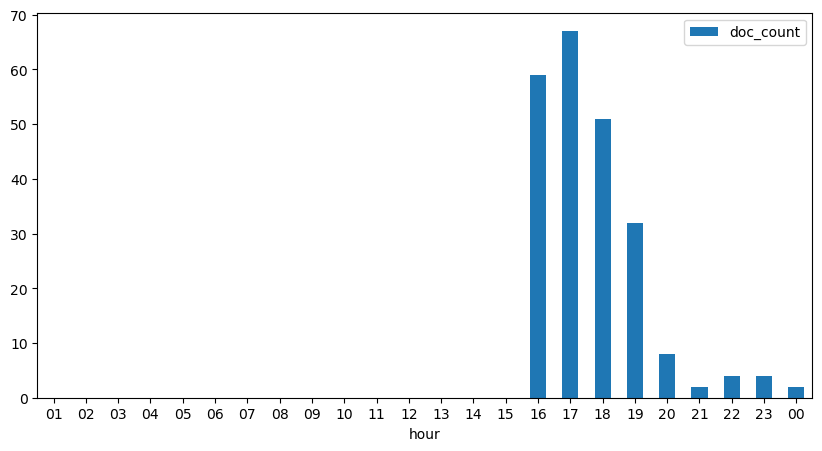

In [11]:
## getting distribution over time and plotting it
import pandas as pd
time_dist = distribution_over_time("26-Feb-1987 00:00:00")

df = pd.DataFrame(time_dist)
df['hour'] = df["key"].apply(lambda x: x[-8:-6]) # extracting the hour from the key
df = df[['hour', 'doc_count']]

df.plot.bar(x='hour', y='doc_count', rot=0, figsize=(10,5))